# Model inference

This notebook allows to load a picture and perform inference with the fine-tuned model by defining a manual box prompt. It also compares the output of the fine-tuned model to the one of MedSAM and SAM ViT-Base.

### Import libraries

In [1]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image

# Set working directory as the main directory. Write you main directory here
os.chdir("...")

/home/ubuntu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fine-tuned model results

### Load image

Adjust the path to load an organoid image.

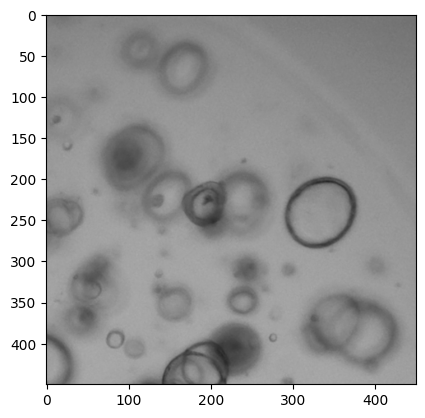

In [2]:
image_path = ".../data/img/path/img_name.jpg"
image = np.asarray(Image.open(image_path).convert("RGB"))
plt.imshow(image, cmap = "gray")

### Box prompt definition

Define the box prompt manually. It can be seen on the image.

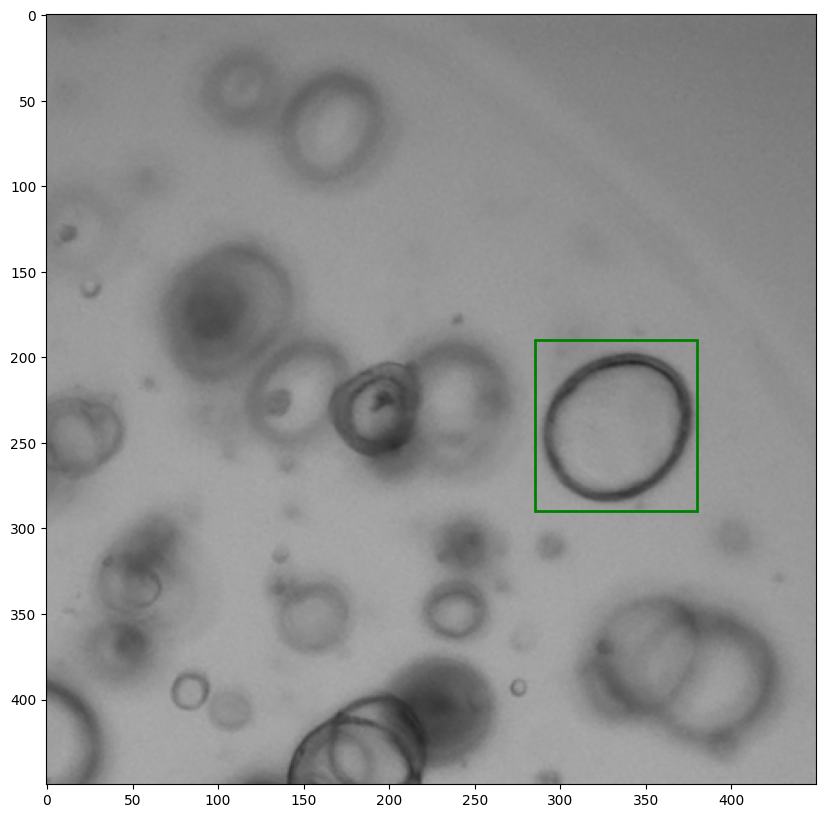

In [3]:
from utils.inference_sam import show_boxes_on_image

box = np.array([[285, 190, 380, 290]])
show_boxes_on_image(image, box)



### Load model

Load the fine-tuned model.

In [4]:
ftmodel = torch.load(".../models/topo+geom_box-prompt.pth")
for name, param in ftmodel.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

### Preprocess the input

In [5]:
from transformers import SamModel, SamProcessor

device = "cuda"

# Use base encoder here
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Get the processed inputs
inputs = processor(image, input_boxes=[[[box]]], return_tensors="pt")

### Get model output and print the results

In [6]:
import torch.nn.functional as F
import numpy as np

def get_mask(model, device, inputs):
    """
     Compute the mask given by a model on the data_item

     Args:
        model: SAM model
        device (string): cuda or cpu
        inputs: output of SAM processor
    Returns:
        mask (torch.Tensor): binarized mask
    """
    # Compute the output of the model
    model.to(device)
    model.eval()
    # Do not compute gradients anywhere
    with torch.no_grad():
        # Forward pass
        outputs = model(pixel_values=inputs["pixel_values"].to(device),
                        input_boxes=inputs["input_boxes"].to(device),
                        multimask_output=False)
        # Get masks
        predicted_masks = outputs.pred_masks.to(device)
        # Masks post processing
        predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                        mode="bilinear", align_corners=False)
        predicted_masks = F.interpolate(predicted_masks, (inputs["original_sizes"].squeeze()[0], inputs["original_sizes"].squeeze()[1]), 
                                        mode="bilinear", align_corners=False)
    
        # Apply sigmoid
        predicted_masks = torch.sigmoid(predicted_masks)

        # Convert soft to hard mask
        mask_seg_prob = predicted_masks.cpu().squeeze(1).detach().numpy()
        mask = (mask_seg_prob > 0.5).astype(np.uint8)
    
    return mask


(-0.5, 449.5, 449.5, -0.5)

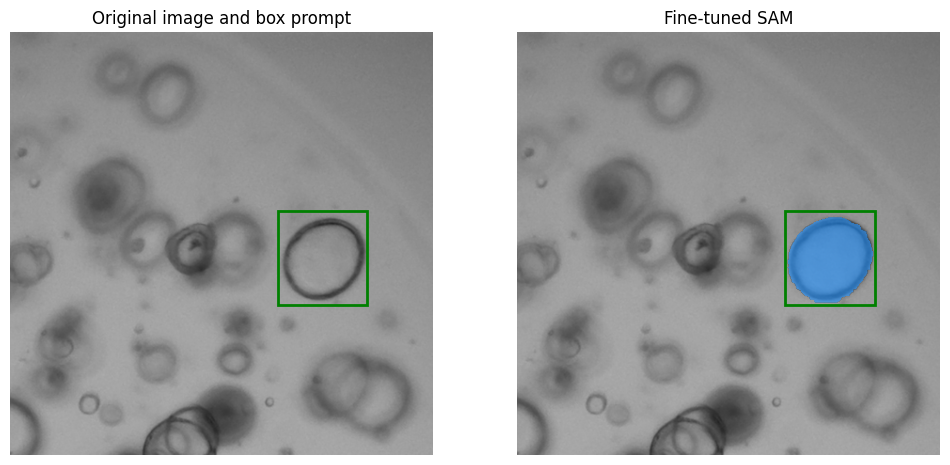

In [7]:
from utils.inference_sam import show_mask, show_box

# Create a figure with one subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 24))

# Plot original input and prompt
axes[0].imshow(image)
# Plot ground truth box
show_box(box[0], axes[0])
axes[0].set_title("Original image and box prompt")
axes[0].axis("off")

# Plot mask given by fine-tuned model
axes[1].imshow(image)
pred_mask = get_mask(ftmodel, "cuda", inputs)
for mask in pred_mask:
    show_mask(mask, axes[1])
    # Plot ground truth box
show_box(box[0], axes[1])
axes[1].set_title("Fine-tuned SAM")
axes[1].axis("off")


## Model comparison

Compare the output of the fine-tuned model with the output given by MedSAM and SAM ViT-Base.



In [8]:
from transformers import SamModel

model_medsam = SamModel.from_pretrained("wanglab/medsam-vit-base")
for name, param in model_medsam.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

model_sam_base = SamModel.from_pretrained("facebook/sam-vit-base")
for name, param in model_sam_base.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

(-0.5, 449.5, 449.5, -0.5)

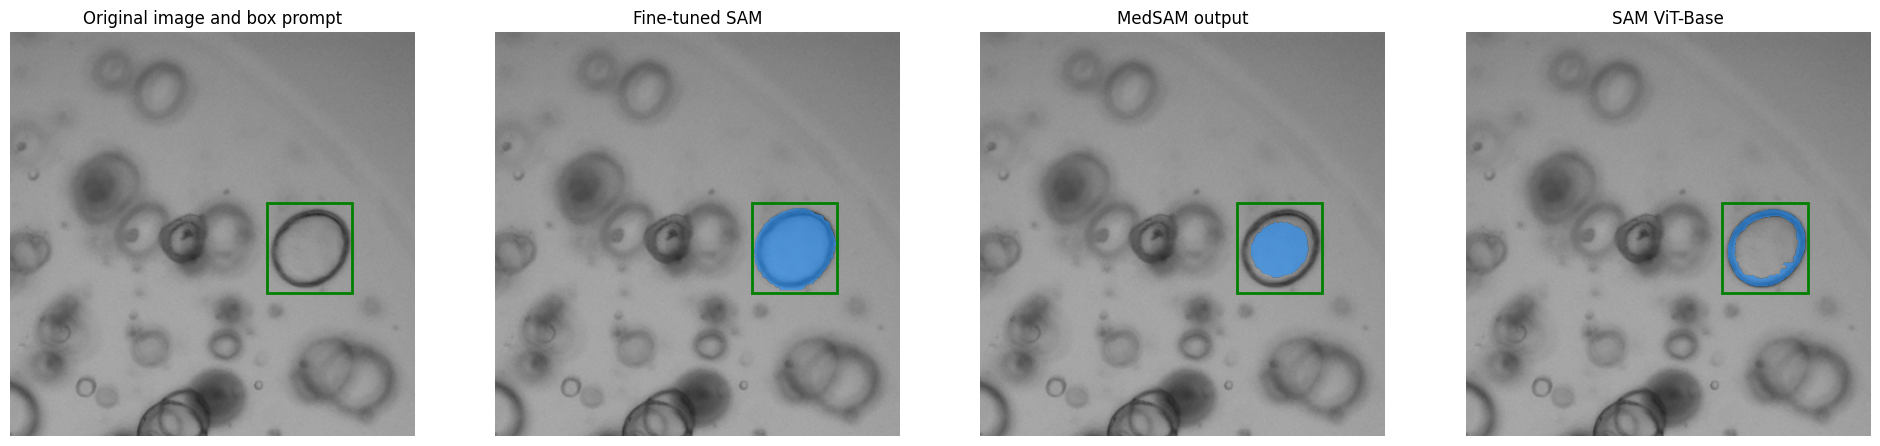

In [9]:
# Create a figure with five subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 12))

# Plot original input and prompt
axes[0].imshow(image)
# Plot ground truth box
show_box(box[0], axes[0])
axes[0].set_title("Original image and box prompt")
axes[0].axis("off")

# Plot mask given by fine-tuned model
axes[1].imshow(image)
pred_mask = get_mask(ftmodel, "cuda", inputs)
for mask in pred_mask:
    show_mask(mask, axes[1])
    # Plot ground truth box
show_box(box[0], axes[1])
axes[1].set_title("Fine-tuned SAM")
axes[1].axis("off")

# Plot mask given by fine-tuned model
axes[2].imshow(image)
pred_mask = get_mask(model_medsam, "cuda", inputs)
for mask in pred_mask:
    show_mask(mask, axes[2])
    # Plot ground truth box
show_box(box[0], axes[2])
axes[2].set_title("MedSAM output")
axes[2].axis("off")

# Plot mask given by fine-tuned model
axes[3].imshow(image)
pred_mask = get_mask(model_sam_base, "cuda", inputs)
for mask in pred_mask:
    show_mask(mask, axes[3])
    # Plot ground truth box
show_box(box[0], axes[3])
axes[3].set_title("SAM ViT-Base")
axes[3].axis("off")